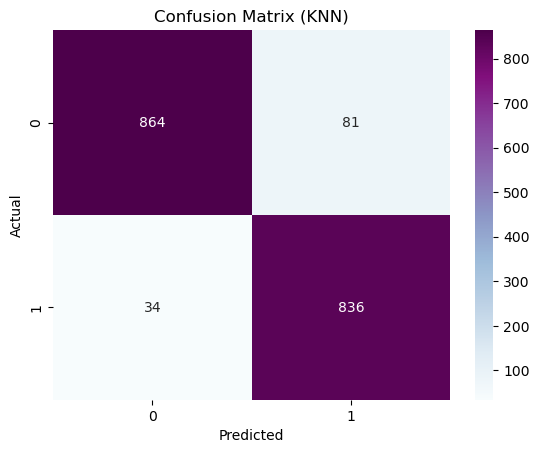

🔎 Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.91      0.94       945
           1       0.91      0.96      0.94       870

    accuracy                           0.94      1815
   macro avg       0.94      0.94      0.94      1815
weighted avg       0.94      0.94      0.94      1815



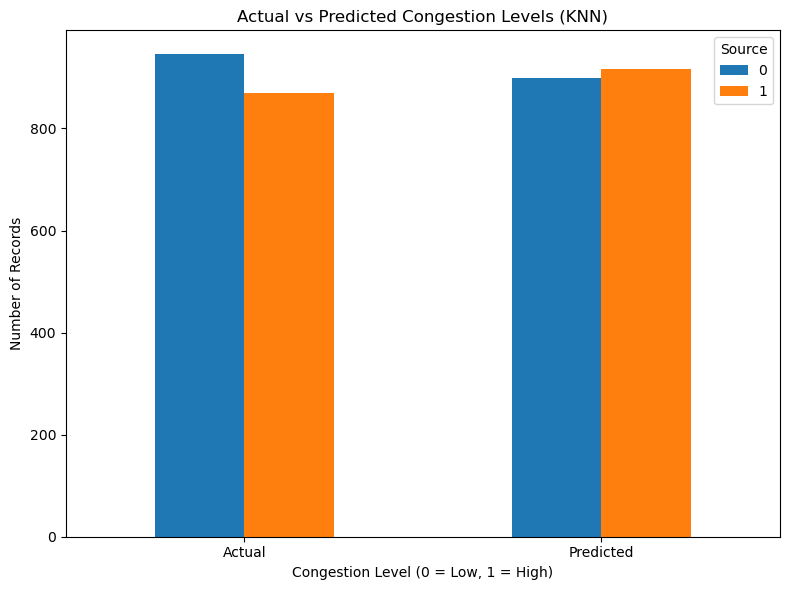

Actual Data:
  - 945 records labeled as Low Congestion (0)
  - 870 records labeled as High Congestion (1)
Predicted Data:
  - 898 predicted as Low Congestion (0)
  - 917 predicted as High Congestion (1)


In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('/Users/harsh/Downloads/MTA_Congestion_Relief_Zone_Vehicle_Entries__Beginning_2025_20250319 - MTA_Congestion_Relief_Zone.csv', na_values='?')

# Drop unnecessary columns
df = df.drop(columns=[
    'Toll Hour', 'Toll 10 Minute Block', 'Day of Week Int', 'Time Period', 'Excluded Roadway Entries'
])

# Set proper data types
df = df.astype({
    'Toll Week': 'datetime64[ns]',
    'Minute of Hour': 'Int64',
    'Hour of Day': 'Int64',
    'Day of Week': 'category',
    'Detection Region': 'category',
    'CRZ Entries': 'Int64'
})

# Aggregate data
df = df.groupby(['Toll Week', 'Hour of Day', 'Day of Week', 'Minute of Hour'], observed=True).agg(
    CRZ_Entries=('CRZ Entries', 'sum')).reset_index()

# Remove missing values
df = df.dropna()

# Create binary classification label
threshold = df['CRZ_Entries'].median()
df['High_Congestion'] = (df['CRZ_Entries'] >= threshold).astype(int)

# Drop datetime column
df = df.drop(columns=['Toll Week'])

# Encode categorical features
X = pd.get_dummies(df.drop(columns=['CRZ_Entries', 'High_Congestion']), drop_first=True)
y = df['High_Congestion']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features (important for distance-based models like KNN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)  # You can try different k values
knn_model.fit(X_train_scaled, y_train)

# Predictions
y_pred = knn_model.predict(X_test_scaled)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='BuPu')
plt.title('Confusion Matrix (KNN)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification Report
print("🔎 Classification Report:\n")
print(classification_report(y_test, y_pred))

# Bar Chart: Actual vs Predicted
actual_counts = y_test.value_counts().sort_index()
predicted_counts = pd.Series(y_pred).value_counts().sort_index()
counts = pd.DataFrame({'Actual': actual_counts, 'Predicted': predicted_counts})

counts.T.plot(kind='bar', figsize=(8, 6))
plt.title('Actual vs Predicted Congestion Levels (KNN)')
plt.xlabel('Congestion Level (0 = Low, 1 = High)')
plt.ylabel('Number of Records')
plt.xticks(rotation=0)
plt.legend(title='Source')
plt.tight_layout()
plt.show()

# Print Summary
print(f"Actual Data:")
print(f"  - {actual_counts[0]} records labeled as Low Congestion (0)")
print(f"  - {actual_counts[1]} records labeled as High Congestion (1)")
print(f"Predicted Data:")
print(f"  - {predicted_counts[0]} predicted as Low Congestion (0)")
print(f"  - {predicted_counts[1]} predicted as High Congestion (1)")
